# Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Check GPU
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(1))

2
NVIDIA GeForce RTX 3090


# Part E

## Implement Custom Resnet + change one layer conv 3 to conv1 

Before Residual Blocks: Placing a 1x1 convolution before the residual blocks (for example, replacing self.conv3) can help in reducing the number of channels entering the residual blocks. This can be beneficial in managing the computational complexity, especially if the number of channels gets large. It acts as a bottleneck layer, reducing dimensionality before processing in the deeper layers.

Before Fully Connected Layers: Alternatively, replacing self.conv4 with a 1x1 convolution can be useful for reducing the feature map depth before it gets flattened and passed into the fully connected layers. This can significantly reduce the number of parameters in the fully connected layers, which can be particularly beneficial if you are dealing with overfitting or computational constraints.

we run second.


In [8]:
class CustomResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(CustomResNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.elu = nn.ELU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

    def forward(self, x):
        shortcut = x
        x = self.conv1(x)
        x = self.elu(x)
        x = self.conv2(x)
        x += shortcut
        x = self.elu(x)
        return x

class CustomResNet(nn.Module):
    def __init__(self):
        super(CustomResNet, self).__init__()
        # Initial convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.elu1 = nn.ELU()
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.elu2 = nn.ELU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        
        # Residual blocks
        self.resblock1 = CustomResNetBlock(64, 64)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.elu3 = nn.ELU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=1, padding=1)
        self.elu4 = nn.ELU()
        self.resblock2 = CustomResNetBlock(256, 256)
        
        # Average pooling and fully connected layers
        self.avgpool = nn.AvgPool2d(kernel_size=3, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(1024, 256)
        self.fc2 = nn.Linear(256, 10)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.elu1(x)
        x = self.conv2(x)
        x = self.elu2(x)
        x = self.maxpool1(x)
        
        x = self.resblock1(x)
        x = self.conv3(x)
        x = self.elu3(x)
        x = self.maxpool2(x)
        x = self.conv4(x)
        x = self.elu4(x)
        x = self.maxpool3(x)
        x = self.resblock2(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

## Load Dataset

In [4]:
# Data augmentation and normalization
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# # Data augmentation and normalization for training
# transform_train = transforms.Compose([
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(15),
#     transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),
#     transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
#     transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# ])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [5]:
# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Splitting train dataset into train and validation sets
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


## Optimizer and Train Setup

In [9]:
# Model, optimizer, and scheduler
model = CustomResNet()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=40, gamma=0.1)
criterion = nn.CrossEntropyLoss()

In [10]:
# Determine if CUDA is available and set the device accordingly
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model.to(device)

CustomResNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (elu1): ELU(alpha=1.0)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (elu2): ELU(alpha=1.0)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (resblock1): CustomResNetBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (elu): ELU(alpha=1.0)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (elu3): ELU(alpha=1.0)
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
  (elu4): ELU(alpha=1.0)
  (resblock2): CustomResNetBlock(
    (conv1): Conv2d(256, 256, kernel_size=(3, 3), str

In [11]:
def train(model, device, train_loader, optimizer, criterion):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

    train_loss /= len(train_loader)
    train_accuracy = 100 * correct / total
    return train_loss, train_accuracy

def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            test_loss += loss.item()
            _, predicted = output.max(1)
            correct += predicted.eq(target).sum().item()

    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

# Training loop with tracking of training and validation accuracies
train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []
best_val_accuracy = 0
best_model_weights = None


In [12]:
for epoch in range(1, 101):
    train_loss, train_accuracy = train(model, device, train_loader, optimizer , criterion)
    val_loss, val_accuracy = test(model, device, val_loader , criterion)

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model_weights = model.state_dict()

    print(f'Epoch: {epoch}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')
    scheduler.step()

Epoch: 1, Train Loss: 2.3022, Train Accuracy: 11.96%, Val Loss: 2.3016, Val Accuracy: 13.28%
Epoch: 2, Train Loss: 2.2998, Train Accuracy: 16.01%, Val Loss: 2.2956, Val Accuracy: 17.90%
Epoch: 3, Train Loss: 2.2570, Train Accuracy: 19.21%, Val Loss: 2.2169, Val Accuracy: 22.86%
Epoch: 4, Train Loss: 2.1997, Train Accuracy: 24.69%, Val Loss: 2.1951, Val Accuracy: 24.88%
Epoch: 5, Train Loss: 2.1840, Train Accuracy: 26.41%, Val Loss: 2.1929, Val Accuracy: 24.96%
Epoch: 6, Train Loss: 2.1760, Train Accuracy: 27.01%, Val Loss: 2.1695, Val Accuracy: 28.02%
Epoch: 7, Train Loss: 2.1598, Train Accuracy: 28.94%, Val Loss: 2.1571, Val Accuracy: 28.98%
Epoch: 8, Train Loss: 2.1382, Train Accuracy: 31.23%, Val Loss: 2.1337, Val Accuracy: 31.88%
Epoch: 9, Train Loss: 2.1186, Train Accuracy: 33.47%, Val Loss: 2.1286, Val Accuracy: 32.64%
Epoch: 10, Train Loss: 2.1048, Train Accuracy: 34.94%, Val Loss: 2.1059, Val Accuracy: 34.44%
Epoch: 11, Train Loss: 2.0921, Train Accuracy: 36.19%, Val Loss: 2.09

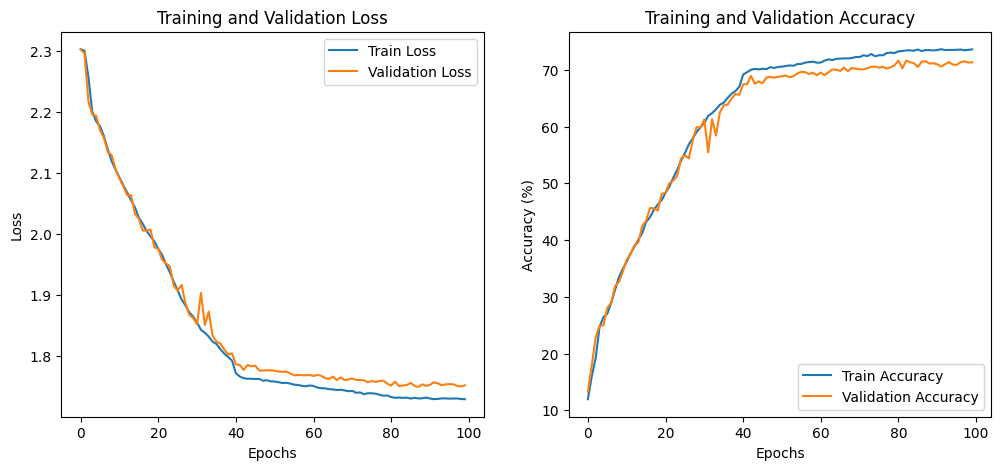

Best Validation Accuracy: 71.62%
Test Accuracy of the final model: 72.18%


In [13]:
# Load best model weights and evaluate on test set
model.load_state_dict(best_model_weights)
test_loss, test_accuracy = test(model, device, test_loader , criterion)

# Plotting training and validation loss and accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

# Print best validation accuracy and test accuracy
print(f'Best Validation Accuracy: {best_val_accuracy:.2f}%')
print(f'Test Accuracy of the final model: {test_accuracy:.2f}%')

# Save best model weights
torch.save(best_model_weights, 'best_custom_resnet_weights_conv1_1.pth')

# Layer Wise analyse , Part A

In [ ]:
#download Pretrained Weight of model
import gdown
id = "1vC1VNVLbjmosc9z5WxRyrOklrlmzqqMj"
gdown.download(id=id, quiet=False)

In [ ]:
!git clone https://github.com/Arhosseini77/data_complexity_measures

In [2]:
from data_complexity_measures.models.ARH_SeparationIndex import ARH_SeparationIndex

In [3]:
class CustomResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(CustomResNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.elu = nn.ELU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

    def forward(self, x):
        shortcut = x
        x = self.conv1(x)
        x = self.elu(x)
        x = self.conv2(x)
        x += shortcut
        x = self.elu(x)
        return x

class CustomResNet(nn.Module):
    def __init__(self):
        super(CustomResNet, self).__init__()
        # Initial convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.elu1 = nn.ELU()
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.elu2 = nn.ELU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        
        # Residual blocks
        self.resblock1 = CustomResNetBlock(64, 64)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.elu3 = nn.ELU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=1, padding=1)
        self.elu4 = nn.ELU()
        self.resblock2 = CustomResNetBlock(256, 256)
        
        # Average pooling and fully connected layers
        self.avgpool = nn.AvgPool2d(kernel_size=3, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(1024, 256)
        self.fc2 = nn.Linear(256, 10)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.elu1(x)
        x = self.conv2(x)
        x = self.elu2(x)
        x = self.maxpool1(x)
        
        x = self.resblock1(x)
        x = self.conv3(x)
        x = self.elu3(x)
        x = self.maxpool2(x)
        x = self.conv4(x)
        x = self.elu4(x)
        x = self.maxpool3(x)
        x = self.resblock2(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

In [4]:
# Data augmentation and normalization
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [5]:
# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Splitting train dataset into train and validation sets
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])


# Further split train_dataset into train_loader_dataset and 20% balanced subset
train_loader_dataset, _ = train_test_split(train_dataset.dataset, train_size=int(0.2 * len(train_dataset)),
                                           test_size=None, shuffle=True, stratify=train_dataset.dataset.targets)

# Data loaders
train_loader = DataLoader(train_loader_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
# Instantiate and load the model
model = CustomResNet()  # Make sure CustomResNet is defined as earlier
model.load_state_dict(torch.load('best_custom_resnet_weights_conv1_1.pth'))
model.to('cuda:1' if torch.cuda.is_available() else 'cpu')
model.eval()

CustomResNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (elu1): ELU(alpha=1.0)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (elu2): ELU(alpha=1.0)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (resblock1): CustomResNetBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (elu): ELU(alpha=1.0)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (elu3): ELU(alpha=1.0)
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
  (elu4): ELU(alpha=1.0)
  (resblock2): CustomResNetBlock(
    (conv1): Conv2d(256, 256, kernel_size=(3, 3), str

In [7]:
# Prepare storage for outputs and labels
features_per_layer = {}
labels_list = []

# Define layers to exclude
exclude_layers = {''}

# Function to attach hooks
def get_layer_outputs(layer_name):
    def hook(module, input, output):
        features_per_layer[layer_name].append(output.detach())
    return hook

# Attach hooks to each layer except the excluded ones
for name, layer in model.named_children():
    if name not in exclude_layers:
        features_per_layer[name] = []
        layer.register_forward_hook(get_layer_outputs(name))

## SI and CenterSI layer for Train Loader

In [8]:
# Pass data through the model and collect layer outputs
with torch.no_grad():
    for inputs, targets in tqdm(train_loader): 
        inputs = inputs.to('cuda:1' if torch.cuda.is_available() else 'cpu')

        # Trigger the hooks and collect layer outputs
        model(inputs)
        labels_list.append(targets.cpu())

        # Clear CUDA cache after processing each batch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# Post-process the data: Flatten and concatenate
for layer_name, layer_features in features_per_layer.items():
    if layer_features:  # Check if layer_features is not empty
        features_per_layer[layer_name] = torch.cat([f.view(f.size(0), -1) for f in layer_features])
    else:
        print(f"No features captured for layer {layer_name}")

# Concatenate the labels
labels = torch.cat(labels_list)

100%|██████████| 36/36 [00:00<00:00, 74.32it/s]


### Calc SI

In [9]:
si_layer_train = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    si = instance_disturbance.si_batch(batch_size=2000)
    si_layer_train.append((layer_name, si))

Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 394.02it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 6693.75it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 8256.50it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 8220.90it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7848.62it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7727.16it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7468.49it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 8025.84it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 2284.98it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 6347.31it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7027.99it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 6730.27it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7836.89it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7825.19it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 6659.74it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7623.24it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7182.03it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7291.91it/s]


In [10]:
si_layer_train

[('conv1', 0.23377777636051178),
 ('elu1', 0.23411111533641815),
 ('conv2', 0.22522222995758057),
 ('elu2', 0.2262222319841385),
 ('maxpool1', 0.3050000071525574),
 ('resblock1', 0.4156666696071625),
 ('maxpool2', 0.5061111450195312),
 ('conv3', 0.4537777900695801),
 ('elu3', 0.45722222328186035),
 ('maxpool3', 0.5064444541931152),
 ('conv4', 0.1792222261428833),
 ('elu4', 0.2598888874053955),
 ('resblock2', 0.5867778062820435),
 ('avgpool', 0.589222252368927),
 ('flatten', 0.589222252368927),
 ('fc1', 0.644777774810791),
 ('fc2', 0.6247777938842773),
 ('softmax', 0.6555555462837219)]

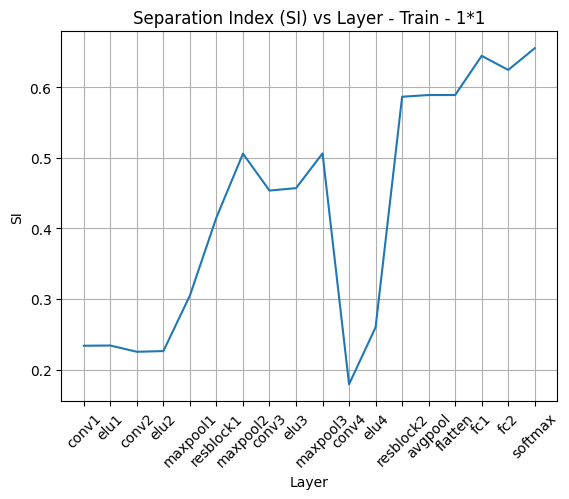

In [11]:
# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in si_layer_train], [si for _, si in si_layer_train])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Separation Index (SI) vs Layer - Train - 1*1')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### Calc Center Si

In [12]:
csi_layer_train = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=2000)
    csi_layer_train.append((layer_name, csi))

Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 701.53it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4519.72it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4029.88it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4492.61it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3130.08it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3258.47it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4086.42it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4635.61it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4857.89it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4264.24it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3991.53it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4106.43it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4245.25it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4065.82it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4366.34it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 2802.93it/s]

Data has been normalized



Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4496.47it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4441.24it/s]


[('conv1', 0.34744444489479065), ('elu1', 0.3494444489479065), ('conv2', 0.3391111195087433), ('elu2', 0.35422223806381226), ('maxpool1', 0.41011112928390503), ('resblock1', 0.5045555830001831), ('maxpool2', 0.5329999923706055), ('conv3', 0.5114444494247437), ('elu3', 0.5277777910232544), ('maxpool3', 0.5479999780654907), ('conv4', 0.5408889055252075), ('elu4', 0.5422222018241882), ('resblock2', 0.6253333687782288), ('avgpool', 0.6116666793823242), ('flatten', 0.6116666793823242), ('fc1', 0.7139999866485596), ('fc2', 0.6834444403648376), ('softmax', 0.7521111369132996)]


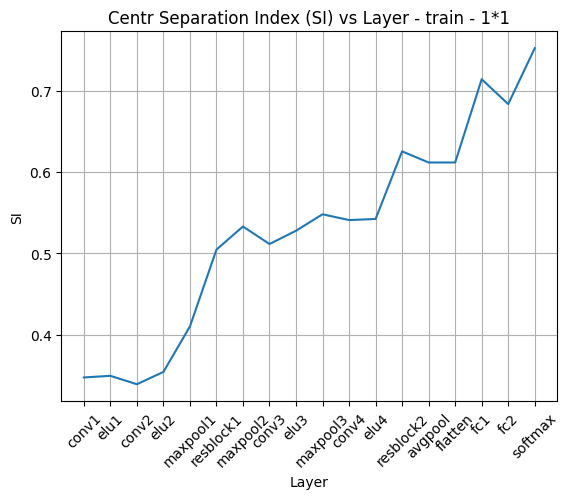

In [13]:
print(csi_layer_train)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train], [si for _, si in csi_layer_train])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Centr Separation Index (SI) vs Layer - train - 1*1')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

## SI and CenterSI layer for Val Loader

In [8]:
# Pass data through the model and collect layer outputs
with torch.no_grad():
    for inputs, targets in tqdm(val_loader): 
        inputs = inputs.to('cuda:1' if torch.cuda.is_available() else 'cpu')

        # Trigger the hooks and collect layer outputs
        model(inputs)
        labels_list.append(targets.cpu())

        # Clear CUDA cache after processing each batch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# Post-process the data: Flatten and concatenate
for layer_name, layer_features in features_per_layer.items():
    if layer_features:  # Check if layer_features is not empty
        # Flatten and concatenate the features for each layer
        features_per_layer[layer_name] = torch.cat([f.view(f.size(0), -1) for f in layer_features])
    else:
        print(f"No features captured for layer {layer_name}")

# Concatenate the labels
labels = torch.cat(labels_list)

100%|██████████| 20/20 [00:00<00:00, 22.82it/s]


### Calc SI

In [9]:
si_layer_val = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    si = instance_disturbance.si_batch(batch_size=2000)
    si_layer_val.append((layer_name, si))

Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 220.63it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5144.28it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 4762.65it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5318.22it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5221.13it/s]

Data has been normalized



Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 4516.48it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5011.12it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5428.35it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5055.41it/s]

Data has been normalized



Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5249.44it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5178.15it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5400.39it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 4809.98it/s]

Data has been normalized



Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5388.83it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5025.12it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 4886.57it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5055.41it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 4813.66it/s]


In [10]:
si_layer_val

[('conv1', 0.22019998729228973),
 ('elu1', 0.21979999542236328),
 ('conv2', 0.21279999613761902),
 ('elu2', 0.21639999747276306),
 ('maxpool1', 0.2809999883174896),
 ('resblock1', 0.4068000018596649),
 ('maxpool2', 0.48339998722076416),
 ('conv3', 0.4333999752998352),
 ('elu3', 0.44339999556541443),
 ('maxpool3', 0.4903999865055084),
 ('conv4', 0.2029999941587448),
 ('elu4', 0.2683999836444855),
 ('resblock2', 0.5649999976158142),
 ('avgpool', 0.5805999636650085),
 ('flatten', 0.5805999636650085),
 ('fc1', 0.6485999822616577),
 ('fc2', 0.6223999857902527),
 ('softmax', 0.6541999578475952)]

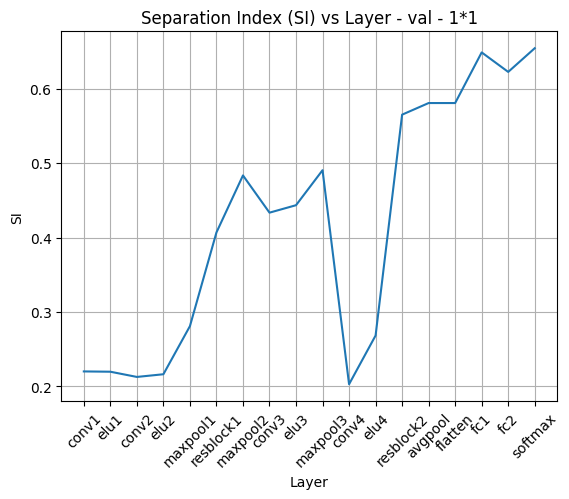

In [11]:
# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in si_layer_val], [si for _, si in si_layer_val])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Separation Index (SI) vs Layer - val - 1*1')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### calc Center SI

In [12]:
csi_layer_val = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=2000)
    csi_layer_val.append((layer_name, csi))

Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 442.30it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3272.54it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3063.03it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3383.41it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3171.10it/s]

Data has been normalized



Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3317.40it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3176.70it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3271.69it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3275.09it/s]

Data has been normalized



Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3160.74it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2904.64it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2976.09it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3225.56it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3770.73it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3433.26it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2364.32it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3655.70it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 4110.72it/s]


[('conv1', 0.34459999203681946), ('elu1', 0.34779998660087585), ('conv2', 0.3449999988079071), ('elu2', 0.3601999878883362), ('maxpool1', 0.4089999794960022), ('resblock1', 0.5065999627113342), ('maxpool2', 0.540399968624115), ('conv3', 0.5127999782562256), ('elu3', 0.5338000059127808), ('maxpool3', 0.5550000071525574), ('conv4', 0.5478000044822693), ('elu4', 0.5475999712944031), ('resblock2', 0.6317999958992004), ('avgpool', 0.6139999628067017), ('flatten', 0.6139999628067017), ('fc1', 0.7117999792098999), ('fc2', 0.686199963092804), ('softmax', 0.7509999871253967)]


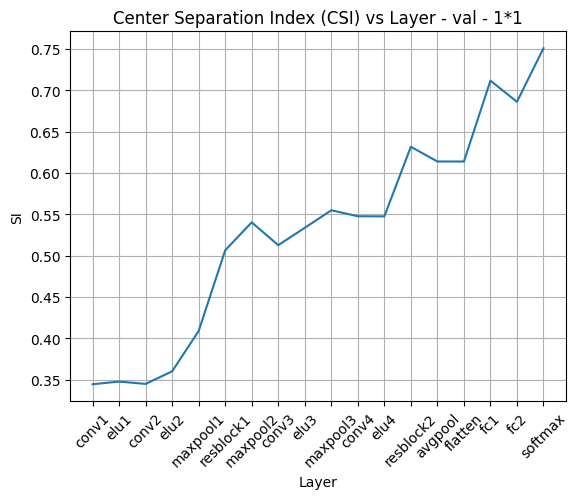

In [13]:
print(csi_layer_val)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_val], [si for _, si in csi_layer_val])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer - val - 1*1')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

## SI and CenterSI layer for Test Loader

In [8]:
# Pass data through the model and collect layer outputs
with torch.no_grad():
    for inputs, targets in tqdm(test_loader):
        inputs = inputs.to('cuda:1' if torch.cuda.is_available() else 'cpu')

        # Trigger the hooks and collect layer outputs
        model(inputs)
        labels_list.append(targets.cpu())

        # Clear CUDA cache after processing each batch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# Post-process the data: Flatten and concatenate
for layer_name, layer_features in features_per_layer.items():
    if layer_features:  # Check if layer_features is not empty
        # Flatten and concatenate the features for each layer
        features_per_layer[layer_name] = torch.cat([f.view(f.size(0), -1) for f in layer_features])
    else:
        print(f"No features captured for layer {layer_name}")

# Concatenate the labels
labels = torch.cat(labels_list)

100%|██████████| 40/40 [00:01<00:00, 26.82it/s]


### Calc SI

In [9]:
si_layer_test = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    si = instance_disturbance.si_batch(batch_size=2000)
    si_layer_test.append((layer_name, si))

Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 373.09it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7487.15it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 6824.45it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7532.87it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7816.44it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7609.40it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7934.74it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7836.89it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7878.11it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7679.06it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7468.49it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 8358.52it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 6382.08it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7587.38it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7639.90it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 2403.34it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 6689.48it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 6561.80it/s]


In [10]:
si_layer_test

[('conv1', 0.23319999873638153),
 ('elu1', 0.2345999926328659),
 ('conv2', 0.2239999920129776),
 ('elu2', 0.22419999539852142),
 ('maxpool1', 0.311599999666214),
 ('resblock1', 0.4251999855041504),
 ('maxpool2', 0.5076000094413757),
 ('conv3', 0.457099974155426),
 ('elu3', 0.46629998087882996),
 ('maxpool3', 0.5054999589920044),
 ('conv4', 0.2117999941110611),
 ('elu4', 0.2865999937057495),
 ('resblock2', 0.5705999732017517),
 ('avgpool', 0.5837000012397766),
 ('flatten', 0.5837000012397766),
 ('fc1', 0.618399977684021),
 ('fc2', 0.6097999811172485),
 ('softmax', 0.6114999651908875)]

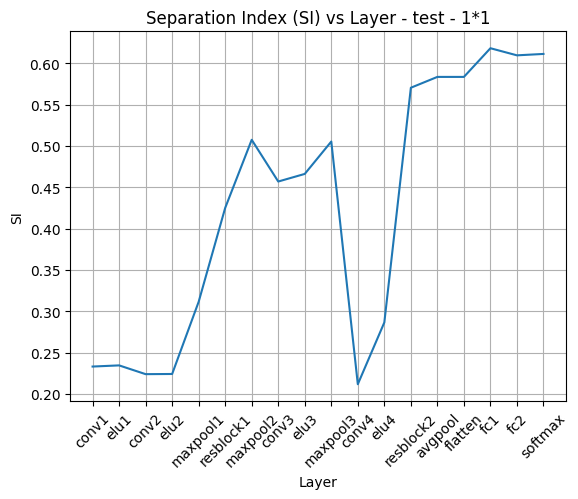

In [11]:
# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in si_layer_test], [si for _, si in si_layer_test])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Separation Index (SI) vs Layer - test - 1*1')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### Calc Center SI

In [12]:
csi_layer_test = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=2000)
    csi_layer_test.append((layer_name, csi))

Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 923.49it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4394.70it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3754.30it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4555.07it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3166.47it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3943.50it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4636.64it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4924.05it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4449.72it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4294.80it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4007.55it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4279.90it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4323.13it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3872.86it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4282.52it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4234.10it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4462.03it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4451.61it/s]


[('conv1', 0.34109997749328613), ('elu1', 0.3447999954223633), ('conv2', 0.33789998292922974), ('elu2', 0.3507999777793884), ('maxpool1', 0.4092999994754791), ('resblock1', 0.501800000667572), ('maxpool2', 0.5321999788284302), ('conv3', 0.5087999701499939), ('elu3', 0.5241999626159668), ('maxpool3', 0.5426999926567078), ('conv4', 0.5412999987602234), ('elu4', 0.5449000000953674), ('resblock2', 0.612500011920929), ('avgpool', 0.6054999828338623), ('flatten', 0.6054999828338623), ('fc1', 0.689300000667572), ('fc2', 0.6603999733924866), ('softmax', 0.7224000096321106)]


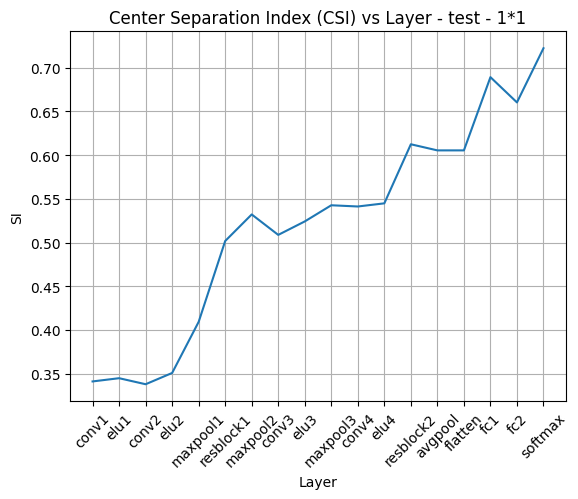

In [13]:
print(csi_layer_test)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_test], [si for _, si in csi_layer_test])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer - test - 1*1')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()